# 課題1(CIFAR10の改良)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 20 # ここは修正してはいけない
batch_size = 200 # ここも修正してはいけない
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [2]:
transform = transforms.Compose([
  transforms.RandomAffine([0,30], scale=(0.8, 1.2)), # 回転および拡大縮小
  transforms.RandomHorizontalFlip(p=0.5), # 左右反転
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [0, 1] => [-1, 1]
])
train_set = torchvision.datasets.CIFAR10(root='mydata', train=True,
                          download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                          shuffle=True, num_workers=4)
test_set = torchvision.datasets.CIFAR10(root='mydata', train=False,
                          download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set),
                          shuffle=False, num_workers=4)

Using downloaded and verified file: mydata/cifar-10-python.tar.gz
Extracting mydata/cifar-10-python.tar.gz to mydata


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


## 問題(1) ネットワークの定義

畳み込み層を深くし、バッチノーマライゼーションを追加した。

In [3]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # 32x32x3 -> 32x32x64
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # 32x32x64 -> 32x32x64
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32x32x64 -> 16x16x64

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 16x16x64 -> 16x16x128
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # 16x16x128 -> 16x16x128
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 16x16x128 -> 8x8x128

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # 8x8x128 -> 8x8x256
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)  # 8x8x256 -> 8x8x256
        self.bn3 = nn.BatchNorm2d(256)
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling

        self.fc1 = nn.Linear(256, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn1(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.bn2(self.conv4(x)))
        x = self.pool2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.bn3(self.conv6(x)))
        x = self.global_pool(x)

        x = x.view(-1, 256)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.fc2(x)
        return x
model = DNN().to(device)
model

DNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=256, out

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def train(train_loader):
  model.train()
  running_loss = 0
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
  train_loss = running_loss / len(train_loader)
  return train_loss

def valid(test_loader):
  model.eval()
  running_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
      predicted = outputs.max(1, keepdim=True)[1]
      correct += predicted.eq(labels.view_as(predicted)).sum().item()
      total += labels.size(0)
  val_loss = running_loss / len(test_loader)
  val_acc = correct / total
  return val_loss, val_acc

loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
  loss = train(train_loader)
  val_loss, val_acc = valid(test_loader)
  print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
        % (epoch, loss, val_loss, val_acc))
  loss_list.append(loss)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)
print('訓練終了 =', val_acc)

epoch 0, loss: 1.4816 val_loss: 1.6430 val_acc: 0.4128
epoch 1, loss: 1.1317 val_loss: 1.2987 val_acc: 0.5294
epoch 2, loss: 0.9762 val_loss: 1.0225 val_acc: 0.6433
epoch 3, loss: 0.8706 val_loss: 1.2164 val_acc: 0.5926
epoch 4, loss: 0.7857 val_loss: 1.0930 val_acc: 0.6373
epoch 5, loss: 0.7205 val_loss: 0.8855 val_acc: 0.7003
epoch 6, loss: 0.6674 val_loss: 0.8717 val_acc: 0.6990
epoch 7, loss: 0.6295 val_loss: 0.8993 val_acc: 0.6974
epoch 8, loss: 0.5872 val_loss: 0.7817 val_acc: 0.7304
epoch 9, loss: 0.5583 val_loss: 0.7392 val_acc: 0.7484
epoch 10, loss: 0.5251 val_loss: 0.6946 val_acc: 0.7664
epoch 11, loss: 0.4986 val_loss: 0.6697 val_acc: 0.7700
epoch 12, loss: 0.4797 val_loss: 0.5922 val_acc: 0.8001
epoch 13, loss: 0.4539 val_loss: 0.5592 val_acc: 0.8083
epoch 14, loss: 0.4370 val_loss: 0.6912 val_acc: 0.7682
epoch 15, loss: 0.4122 val_loss: 0.5841 val_acc: 0.8073
epoch 16, loss: 0.4060 val_loss: 0.5855 val_acc: 0.8005
epoch 17, loss: 0.3773 val_loss: 0.7012 val_acc: 0.7778
ep

## **実行結果が0.8を超えた**

## 結果表示

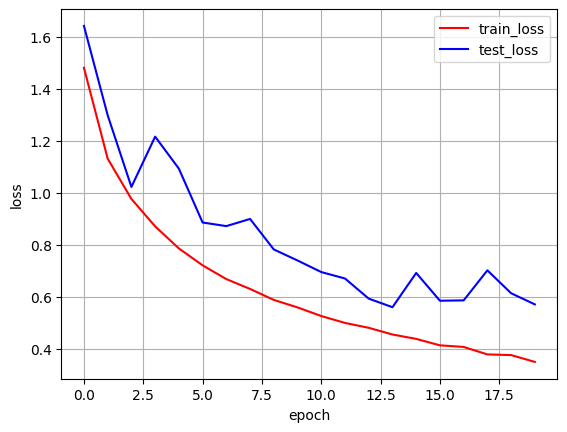

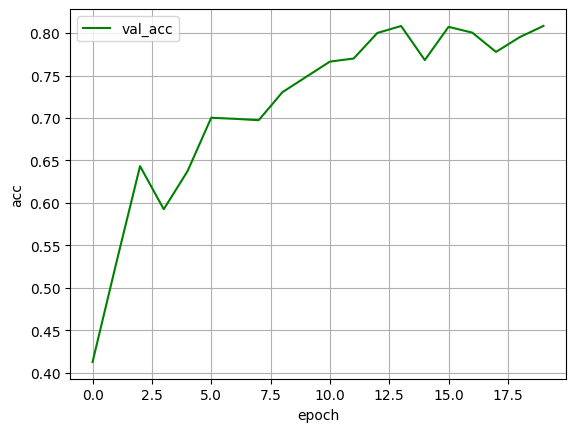

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='test_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()

実際に画像認識があっているかどうか確認してみる。

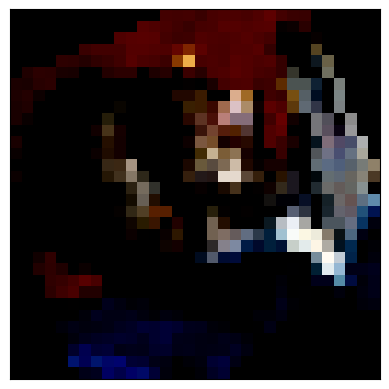

正解: cat 予測結果: cat


In [6]:
dataiter = iter(test_loader)
images, labels = next(dataiter)  # サンプルを1つだけ取り出す

plt.imshow(np.transpose(images[0], (1, 2, 0)))  # チャンネルを一番後ろに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

model.eval()  # 評価モード
imagee, labele = images.cuda(), labels.cuda()  # GPU対応
with torch.no_grad():
  labely = model(imagee)
print("正解:", classes[labels[0]],
      "予測結果:", classes[labely[0].argmax().item()])

とても私の目ではこの画像が猫であることは判別できないがなんかあっている

## 問題(2)  データ拡張

In [7]:
!rm -r ./mydata

In [8]:
transform = transforms.Compose([
  transforms.RandomAffine([0,30], scale=(0.8, 1.2)), # 回転および拡大縮小
  transforms.RandomHorizontalFlip(p=0.5), # 左右反転
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # [0, 1] => [-1, 1]
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
])
train_set = torchvision.datasets.CIFAR10(root='mydata', train=True,
                          download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                          shuffle=True, num_workers=4)
test_set = torchvision.datasets.CIFAR10(root='mydata', train=False,
                          download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set),
                          shuffle=False, num_workers=4)

100%|██████████| 170498071/170498071 [00:03<00:00, 43131681.90it/s]


Extracting mydata/cifar-10-python.tar.gz to mydata
Files already downloaded and verified


In [9]:
model = DNN().to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def train(train_loader):
  model.train()
  running_loss = 0
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
  train_loss = running_loss / len(train_loader)
  return train_loss

def valid(test_loader):
  model.eval()
  running_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
      predicted = outputs.max(1, keepdim=True)[1]
      correct += predicted.eq(labels.view_as(predicted)).sum().item()
      total += labels.size(0)
  val_loss = running_loss / len(test_loader)
  val_acc = correct / total
  return val_loss, val_acc

loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
  loss = train(train_loader)
  val_loss, val_acc = valid(test_loader)
  print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
        % (epoch, loss, val_loss, val_acc))
  loss_list.append(loss)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)
print('訓練終了 =', val_acc)

epoch 0, loss: 1.6036 val_loss: 1.8064 val_acc: 0.3805
epoch 1, loss: 1.2683 val_loss: 1.3925 val_acc: 0.5082
epoch 2, loss: 1.1095 val_loss: 1.2890 val_acc: 0.5651
epoch 3, loss: 0.9996 val_loss: 1.3599 val_acc: 0.5472
epoch 4, loss: 0.9190 val_loss: 1.0825 val_acc: 0.6158
epoch 5, loss: 0.8574 val_loss: 1.2147 val_acc: 0.6124
epoch 6, loss: 0.8151 val_loss: 1.1287 val_acc: 0.6043
epoch 7, loss: 0.7602 val_loss: 0.9002 val_acc: 0.6837
epoch 8, loss: 0.7337 val_loss: 0.9687 val_acc: 0.6656
epoch 9, loss: 0.7086 val_loss: 0.9756 val_acc: 0.6660
epoch 10, loss: 0.6841 val_loss: 0.9099 val_acc: 0.6830
epoch 11, loss: 0.6517 val_loss: 0.7923 val_acc: 0.7260
epoch 12, loss: 0.6271 val_loss: 0.7284 val_acc: 0.7519
epoch 13, loss: 0.6067 val_loss: 0.6911 val_acc: 0.7589
epoch 14, loss: 0.5825 val_loss: 0.7511 val_acc: 0.7389
epoch 15, loss: 0.5684 val_loss: 0.6743 val_acc: 0.7693
epoch 16, loss: 0.5477 val_loss: 0.8554 val_acc: 0.7245
epoch 17, loss: 0.5333 val_loss: 0.6920 val_acc: 0.7646
ep

# 課題2(誤り訂正)

100%|██████████| 9912422/9912422 [00:00<00:00, 124737736.44it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 28118777.58it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35586373.42it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2176954.49it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch: 1/10, Loss: 0.7135518193244934
Epoch: 2/10, Loss: 0.28445878624916077
Epoch: 3/10, Loss: 0.22388525307178497
Epoch: 4/10, Loss: 0.18892312049865723
Epoch: 5/10, Loss: 0.16314461827278137
Epoch: 6/10, Loss: 0.14336684346199036
Epoch: 7/10, Loss: 0.12710700929164886
Epoch: 8/10, Loss: 0.11398613452911377
Epoch: 9/10, Loss: 0.10254968702793121
Epoch: 10/10, Loss: 0.0924142524600029
Loss: 0.1072487365908739, Accuracy: 96.74% (9674/10000)


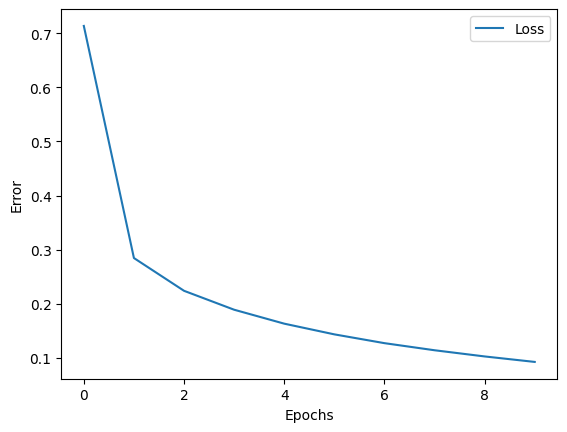

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import sys
epochs = 10         # エポック数
batch = 123         # ミニバッチサイズ
learning_rate = 0.001   # 学習率
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data',train = True,download = True,transform = transform)
test_dataset = datasets.MNIST('./data',train = False,transform = transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size = batch,shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size = batch,shuffle = True)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
model.train()  # モデルを訓練モードにする
loss_rec = []
for epoch in range(epochs): # 学習を繰り返し行う
    loss_sum = 0
    for (inputs, labels) in train_dataloader: #<<修正箇所1>>
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        inputs = inputs.view(-1, 28*28) #<<修正箇所2>>
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_sum += loss
        loss.backward()
        optimizer.step()
    loss_rec.append(loss_sum.item()/len(train_dataloader)) #<<修正箇所3>>
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {loss_sum / len(train_dataloader)}")
model.eval()  # モデルを評価モードにする
loss_sum = 0
correct = 0
with torch.no_grad():
    for batch_inputs in test_dataloader:
        inputs = batch_inputs[0].to(device) #<<修正箇所4>>
        labels = batch_inputs[1].to(device) #<<修正箇所5>>
        inputs = inputs.view(-1 ,28*28) #<<修正箇所6>>
        outputs = model(inputs)
        loss_sum += criterion(outputs, labels)
        pred = outputs.argmax(1)
        correct += pred.eq(labels.view_as(pred)).sum().item()
print(f"Loss: {loss_sum.item() / len(test_dataloader)}, Accuracy: {100*correct/len(test_dataset)}% ({correct}/{len(test_dataset)})")
plt.plot(range(len(loss_rec)), loss_rec, label="Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

- 修正箇所1 -->  train_dataloaderはimage と labelをセットで返すため、二つを受け取るようにする。
- 修正箇所2 --> modelの入力データの形に合わせる(ここでは列数にfc1の入力28*28を指定)
- 修正箇所3 --> loss_sum は GPUで計算した値であり、GPU上のメモリに存在する。また勾配情報はここでは必要ではないため.item()とする。
- 修正箇所4, 修正箇所5 --> 修正箇所1と同様の理由によりリストとして受け取り、imageとlabelの二つを分ける。
- 修正箇所6 --> 修正箇所2 と同様

# 課題3 (StyleTransfer)

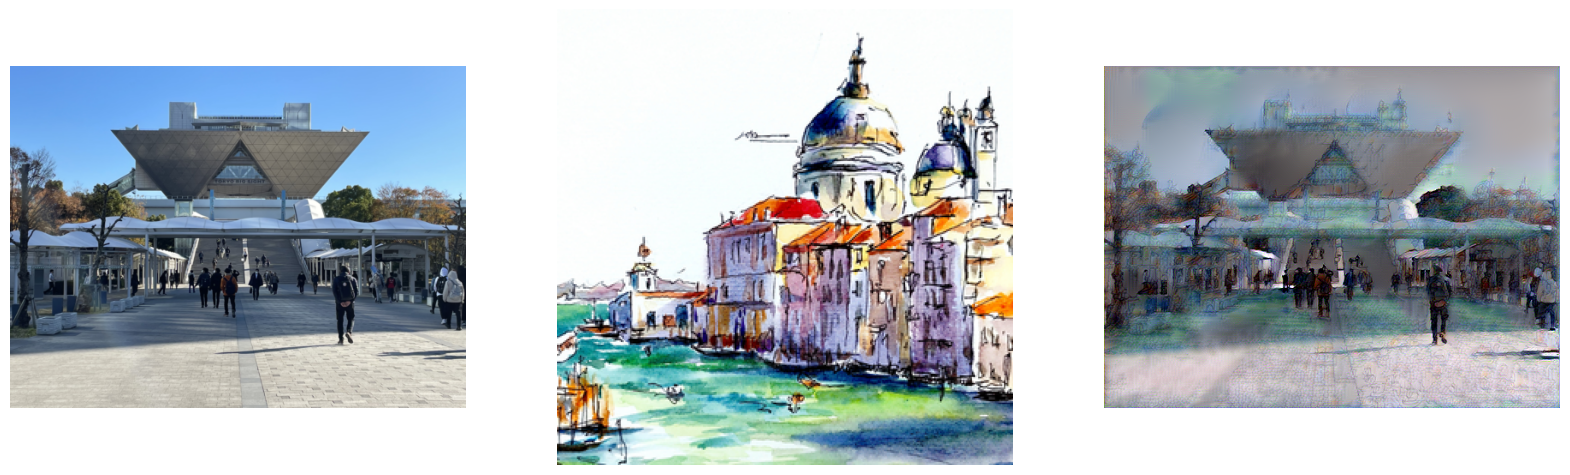